# Graph Creation with CAG

In [ ]:
!pip show cag

# Make sure you have cag >1.0.0

## b) Define your graph components

We want to create the graph, *MyFirstCag*.
*MyFirstCag* will be built using Wikipedia page revisions.

The image below shows the nodes and relations of the graph. The nodes in blue are the ones that we have to define. Whereas the other nodes are already pre-defined by CAG.

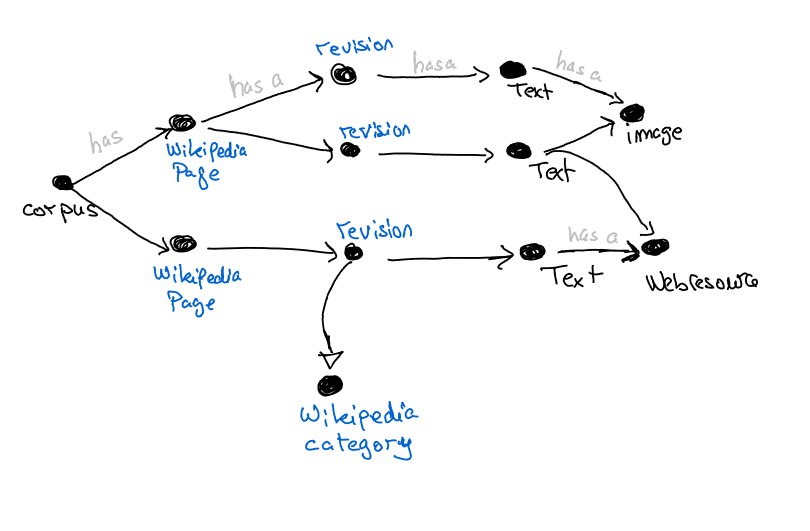

### i) Nodes (a.k.a Vertices)

In [ ]:
from cag.graph_elements.nodes import GenericOOSNode, Field

In [ ]:
## Add type
class WikipediaArticle(GenericOOSNode):
    _fields = {"name": Field(), "language": Field(), **GenericOOSNode._fields}


class WikipediaRevision(GenericOOSNode):
    _fields = {"rev_id": Field(), "rev_timestamp": Field(), **GenericOOSNode._fields}


class WikipediaCategory(GenericOOSNode):
    _fields = {"name": Field(), **GenericOOSNode._fields}


### ii) Relations (a.k.a Edges)

In [ ]:
from cag.graph_elements.relations import GenericEdge

In [ ]:
class HasA(GenericEdge):
    _fields = GenericEdge._fields


### iii) Graph 

### a) Create your Graph with *GraphCreatorBase*

In [ ]:
# from cag.graph_elements.base_graph import BaseGraph
# from pyArango.graph import  EdgeDefinition

In [ ]:
from cag.framework.creator.base_creator import GraphCreatorBase

# from cag.utils.config import Config
from glob import glob
import pandas as pd

In [ ]:
class MyGraphCreator(GraphCreatorBase):
    _name = "WikipediaML"
    _description = "Wikipedia ML revisions"

    ### your code here: Add __init__ Here ##
    _WIKIPEDIA_ARTICLE_NODE = (
        WikipediaArticle.__name__
    )  # should be the exact name as the class name
    _WIKIPEDIA_REVISION_NODE = WikipediaRevision.__name__
    _WIKIPEDIA_CATEGORY_NODE = WikipediaCategory.__name__

    _HAS_A_RELATION = HasA.__name__

    _edge_definitions = [
        {
            "relation": _HAS_A_RELATION,
            "from_collections": [
                GraphCreatorBase._TEXT_NODE_NAME,
                GraphCreatorBase._CORPUS_NODE_NAME,
                _WIKIPEDIA_ARTICLE_NODE,
                _WIKIPEDIA_REVISION_NODE,
            ],
            "to_collections": [
                GraphCreatorBase._IMAGE_NODE_NAME,
                GraphCreatorBase._WEB_RESOURCE_NODE_NAME,
                GraphCreatorBase._TEXT_NODE_NAME,
                _WIKIPEDIA_ARTICLE_NODE,
                _WIKIPEDIA_REVISION_NODE,
                _WIKIPEDIA_CATEGORY_NODE,
            ],
        },
    ]

    ### your code here: Add __init__ Here ##

    # -------------------------------------------

    ### your code here: Add init_graph(self) here ##
    def init_graph(self):
        print(self.corpus_file_or_dir)
        wiki_files = glob(self.corpus_file_or_dir)
        print("there are {} wiki titles".format(len(wiki_files)))
        node_corpus = self.create_corpus_node(
            key="WikipediaML",
            name=MyGraphCreator._name,
            type="social_media",
            desc=MyGraphCreator._description,
            created_on=self.now,
            timestamp=self.now,
        )

        for wiki_file in wiki_files:
            page_revs_df = pd.read_parquet(wiki_file)

            page_revs_df["timestamp_str"] = page_revs_df["timestamp"]
            page_revs_df["timestamp"] = pd.to_datetime(
                page_revs_df["timestamp"], infer_datetime_format=True
            )
            page_revs_df = page_revs_df.sort_values(by=["timestamp"])

            ## create wikipedia page
            page_name = page_revs_df["page"][0]
            language = page_revs_df["lang"][0]

            node_wikiarticle = self.upsert_node(
                MyGraphCreator._WIKIPEDIA_ARTICLE_NODE,
                {
                    "name": page_name,
                    "lang": language,
                    "timestamp": page_revs_df["timestamp"].max(),
                },
                ["name"],
            )

            ## create wikipedia link
            self.upsert_edge(
                MyGraphCreator._HAS_A_RELATION,  # relation name
                node_corpus,  # from
                node_wikiarticle,  # to
                {"timestamp": page_revs_df["timestamp"].max()},
            )

            for _, revision in page_revs_df.iterrows():
                # WikipediaRevision
                revision_timestamp = revision["timestamp"]
                revision_id = revision["page"] + revision["timestamp_str"]

                node_revision = self.upsert_node(
                    MyGraphCreator._WIKIPEDIA_REVISION_NODE,
                    {
                        "rev_id": revision_id,
                        "rev_timestamp": revision_timestamp,
                        "timestamp": revision_timestamp,
                    },
                    alt_key=["rev_id"],
                )

                self.upsert_edge(
                    MyGraphCreator._HAS_A_RELATION,  # relation name
                    node_wikiarticle,  # from
                    node_revision,  # to
                    {"timestamp": revision_timestamp},
                )

                # TextNode
                txt = revision["content"]
                node_text = self.create_text_node(txt)
                self.upsert_edge(
                    MyGraphCreator._HAS_A_RELATION,
                    node_revision,
                    node_text,
                    {"timestamp": revision["timestamp"]},
                )

                # Webresources
                for webresource in revision["urls"]:
                    node_webresource = self.create_web_resource_node(webresource)
                    self.upsert_edge(
                        MyGraphCreator._HAS_A_RELATION,
                        node_text,
                        node_webresource,
                        {"timestamp": revision["timestamp"]},
                    )

                # WikipediaCategory
                for category in revision["categories"]:
                    node_category = self.upsert_node(
                        MyGraphCreator._WIKIPEDIA_CATEGORY_NODE,
                        {"name": category},
                        alt_key=["name"],
                    )
                    self.upsert_edge(
                        MyGraphCreator._HAS_A_RELATION,
                        node_text,
                        node_category,
                        {"timestamp": revision["timestamp"]},
                    )

                # ImageNode
                for image in revision["images"]:
                    node_image = self.create_image_node(image)
                    self.upsert_edge(
                        MyGraphCreator._HAS_A_RELATION,
                        node_text,
                        node_image,
                        {"timestamp": revision["timestamp"]},
                    )

        return self.graph

    # -------------------------------------------

    ### add update_graph here ##
    def update_graph(self, timestamp):
        return self.init_graph()

    # -------------------------------------------

### Set your connection

In [ ]:
import cag.utils.config as graph_config

In [ ]:
my_config = graph_config.Config(
    url="http://127.0.0.1:8529",
    user="root",
    password="root",
    database="InsightsNet",
    graph="MyFirstCagGraph",
)

### Create graph

In [11]:
from cag.utils.timer import Timer

t = Timer()
t.start()
wgc = MyGraphCreator(
    r"data/periodic_wiki_batches/Machine_learning/10Oct2021-12Oct2021/*.parquet",
    my_config,
    initialize=True,
    load_generic_graph=True,
)
t.stop()

## Visualize

In [ ]:
%pip install graphistry

In [ ]:
paths = my_config.arango_db.graph("MyFirstCagGraph").traverse(
    start_vertex="WikipediaArticle/8228",  # get a node from your arangoDB > Collections> WikipedidaArticle> select any key
    direction="outbound",
    strategy="breadthfirst",
)["paths"]

In [ ]:
def paths_to_graph(paths, source="_from", destination="_to", node="_id"):
    nodes_df = pd.DataFrame()
    edges_df = pd.DataFrame()
    for graph in paths:
        nodes_df = pd.concat(
            [nodes_df, pd.DataFrame(graph["vertices"])], ignore_index=True
        )
        edges_df = pd.concat(
            [edges_df, pd.DataFrame(graph["edges"])], ignore_index=True
        )
    nodes_df = nodes_df.drop_duplicates([node])
    edges_df = edges_df.drop_duplicates([node])
    return (
        graphistry.bind(source=source, destination=destination, node=node)
        .nodes(nodes_df)
        .edges(edges_df)
    )


def graph_to_graphistry(graph, source="_from", destination="_to", node="_id"):
    nodes_df = pd.DataFrame()
    for vc_name in graph.vertex_collections():
        nodes_df = pd.concat(
            [nodes_df, pd.DataFrame([x for x in graph.vertex_collection(vc_name)])],
            ignore_index=True,
        )
    edges_df = pd.DataFrame()
    for edge_def in graph.edge_definitions():
        edges_df = pd.concat(
            [
                edges_df,
                pd.DataFrame(
                    [x for x in graph.edge_collection(edge_def["edge_collection"])]
                ),
            ],
            ignore_index=True,
        )
    return (
        graphistry.bind(source=source, destination=destination, node=node)
        .nodes(nodes_df)
        .edges(edges_df)
    )

In [ ]:
import graphistry

graphistry.register(
    api=3, username="username", password="password"
)  # Free account: hub.graphistry.com

In [ ]:
from arango import ArangoClient
import pandas as pd

g = paths_to_graph(paths)
g.bind(point_title="name").plot()

In [ ]:
g = graph_to_graphistry(my_config.arango_db.graph("MyFirstCagGraph"))
g.bind(point_title="name").plot()